### Download C4 dataset and install requirements

In [2]:
!wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
!mkdir -p content
%cd content
!wget https://raw.githubusercontent.com/RepoAnalysis/PythonCloneDetection/main/examples/c4.csv
!wget https://raw.githubusercontent.com/RepoAnalysis/PythonCloneDetection/main/results/res.csv
%cd ..
!pip install -U transformers
!pip install -U sentence_transformers

--2023-07-12 05:38:54--  https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10352 (10K) [text/plain]
Saving to: ‘unixcoder.py’

unixcoder.py        100%[===================>]  10.11K  --.-KB/s    in 0s      

2023-07-12 05:38:54 (122 MB/s) - ‘unixcoder.py’ saved [10352/10352]

/content/content
--2023-07-12 05:38:54--  https://raw.githubusercontent.com/RepoAnalysis/PythonCloneDetection/main/examples/c4.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

### Perform models inference on the [C4 dataset](https://github.com/Chenning-Tao/C4/tree/main/dataset)

In [1]:
import torch
import time
import pandas as pd
from tqdm import tqdm
from unixcoder import UniXcoder
from torch.nn import CosineSimilarity
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer

df = pd.read_csv("content/c4.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cossim = CosineSimilarity(dim=1, eps=1e-8)
model_clone_detection = UniXcoder("Lazyhope/unixcoder-clone-detection")
model_code_search = UniXcoder("Lazyhope/unixcoder-nine-advtest")

model_clone_detection.to(device)
model_code_search.to(device)
tqdm.pandas()

model_codet5 = "Salesforce/codet5-base-multi-sum"
tokenizer = AutoTokenizer.from_pretrained(model_codet5)
model_codet5_sum = AutoModelForSeq2SeqLM.from_pretrained(model_codet5)
text_model = SentenceTransformer("all-mpnet-base-v2", device=device)

def get_code_embeddings(code, model):
    tokens_ids = model.tokenize([code], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)

    return embeddings

def get_pair_similarity(code1, code2, model):
    e1, e2 = get_code_embeddings(code1, model), get_code_embeddings(code2, model)
    score = cossim(e1, e2).cpu().item()
    return score

def get_code_sum_embedding(func):
    inputs = tokenizer.batch_encode_plus(
        func,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    with torch.no_grad():
        inputs = {k: v.to(model_codet5_sum.device) for k, v in inputs.items()}
        outputs = model_codet5_sum.generate(**inputs)
    code_snippet_summarization = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return text_model.encode(code_snippet_summarization, convert_to_tensor=True)

def get_pair_sum_similarity(sum1, sum2):
    e3, e4 = get_code_sum_embedding(sum1), get_code_sum_embedding(sum2)
    score = cossim(e3, e4).cpu().item()
    return score


e:\Miniconda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with torch.no_grad():
    data_subset = df[:1000]
    print("Inferencing with UniXCoder Clone Detection Model...")
    start_time = time.time()
    clone_detection_scores = data_subset.progress_apply(lambda row: get_pair_similarity(row["code1"], row["code2"], model_clone_detection), axis=1)
    end_time = time.time()
    clone_detection_inference_time = end_time - start_time
    print("Inferencing time for UniXCoder Clone Detection Model:", clone_detection_inference_time, "seconds")
    print("------------------------------------------")

    print("Inferencing with UniXCoder Code Search Model...")
    start_time = time.time()
    code_search_scores = data_subset.progress_apply(lambda row: get_pair_similarity(row["code1"], row["code2"], model_code_search), axis=1)
    end_time = time.time()
    code_search_inference_time = end_time - start_time
    print("Inferencing time for UniXCoder Code Search Model:", code_search_inference_time, "seconds")
    print("------------------------------------------")

    print("Inferencing with CodeT5 Code Summarization Model...")
    start_time = time.time()
    clone_sum_scores = data_subset.progress_apply(lambda row: get_pair_sum_similarity([row["code1"]], [row["code2"]]), axis=1)
    end_time = time.time()
    clone_sum_inference_time = end_time - start_time
    print("Inferencing time for CodeT5 Code Summarization Model:", clone_sum_inference_time, "seconds")



Inferencing with UniXCoder Clone Detection Model...


100%|██████████| 1000/1000 [01:33<00:00, 10.68it/s]


Inferencing time for UniXCoder Clone Detection Model: 93.6576337814331 seconds
------------------------------------------
Inferencing with UniXCoder Code Search Model...


100%|██████████| 1000/1000 [01:30<00:00, 11.08it/s]


Inferencing time for UniXCoder Code Search Model: 90.24951934814453 seconds
------------------------------------------
Inferencing with CodeT5 Code Summarization Model...


  0%|          | 0/1000 [00:00<?, ?it/s]e:\Miniconda\envs\pytorch\lib\site-packages\transformers\generation\utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1000/1000 [33:07<00:00,  1.99s/it]

Inferencing time for CodeT5 Code Summarization Model: 1987.161724805832 seconds


## Find the optimal threshold that has maximum f1 score

In [5]:
from sklearn.metrics import recall_score, precision_score, f1_score

def get_optimal_threshold(scores):
    y_true = data_subset["similar"]
    max_tuple = (0, 1) # (f1 score, threshold)
    for threshold in scores:
        y_pred = scores >= threshold
        f1 = f1_score(y_true, y_pred)
        if f1 > max_tuple[0]:
            max_tuple = (f1, threshold)

    optimal_threshold = max_tuple[1]
    return optimal_threshold

In [6]:
print("Finding optimal threshold for UniXCoder - Clone Detection Model")
clone_detection_threshold = get_optimal_threshold(clone_detection_scores)
print(f"Optimal threshold: {clone_detection_threshold}")
print("------------------------------------------")


print("Finding optimal threshold for UniXCoder - Code Search Model")
code_search_threshold = get_optimal_threshold(code_search_scores)
print(f"Optimal threshold: {code_search_threshold}")
print("------------------------------------------")


print("Finding optimal threshold for CodeT5 - Code Summarization Model")
clone_sum_threshold = get_optimal_threshold(clone_sum_scores)
print(f"Optimal threshold: {clone_sum_threshold}")

Finding optimal threshold for UniXCoder - Clone Detection Model
Optimal threshold: 0.4399557113647461
------------------------------------------
Finding optimal threshold for UniXCoder - Code Search Model
Optimal threshold: 0.6748824715614319
------------------------------------------
Finding optimal threshold for CodeT5 - Code Summarization Model
Optimal threshold: 0.41249266266822815


### Highest F1 score

In [9]:
y_true_orgin = df["similar"]
y_true = y_true_orgin[:1000]

y_pred = pd.read_csv("content/res.csv")["predictions"]
print("GraphCodeBERT Model")
print(f"Recall: {recall_score(y_true_orgin, y_pred)}")
print(f"Precision: {precision_score(y_true_orgin, y_pred)}")
print(f"F1: {f1_score(y_true_orgin, y_pred)}")
print("------------------------------------------")

clone_detection_pred = clone_detection_scores >= clone_detection_threshold
print("UniXCoder - Clone Detection Model")
print(f"Recall: {recall_score(y_true, clone_detection_pred)}")
print(f"Precision: {precision_score(y_true, clone_detection_pred)}")
print(f"F1: {f1_score(y_true, clone_detection_pred)}")
print("------------------------------------------")

print("UniXCoder - Code Search Model")
code_search_pred = code_search_scores >= code_search_threshold
print(f"Recall: {recall_score(y_true, code_search_pred)}")
print(f"Precision: {precision_score(y_true, code_search_pred)}")
print(f"F1: {f1_score(y_true, code_search_pred)}")
print("------------------------------------------")


print("CodeT5 - Code Summarization Model")
clone_sum_pred = clone_sum_scores >= clone_sum_threshold
print(f"Recall: {recall_score(y_true, clone_sum_pred)}")
print(f"Precision: {precision_score(y_true, clone_sum_pred)}")
print(f"F1: {f1_score(y_true, clone_sum_pred)}")



GraphCodeBERT Model
Recall: 0.9642440163455925
Precision: 0.97563496751329
F1: 0.969906048150323
------------------------------------------
UniXCoder - Clone Detection Model
Recall: 0.9409448818897638
Precision: 0.9637096774193549
F1: 0.952191235059761
------------------------------------------
UniXCoder - Code Search Model
Recall: 0.84251968503937
Precision: 0.8681541582150102
F1: 0.8551448551448552
------------------------------------------
CodeT5 - Code Summarization Model
Recall: 0.6456692913385826
Precision: 0.8608923884514436
F1: 0.7379077615298089


## ROC and AUC

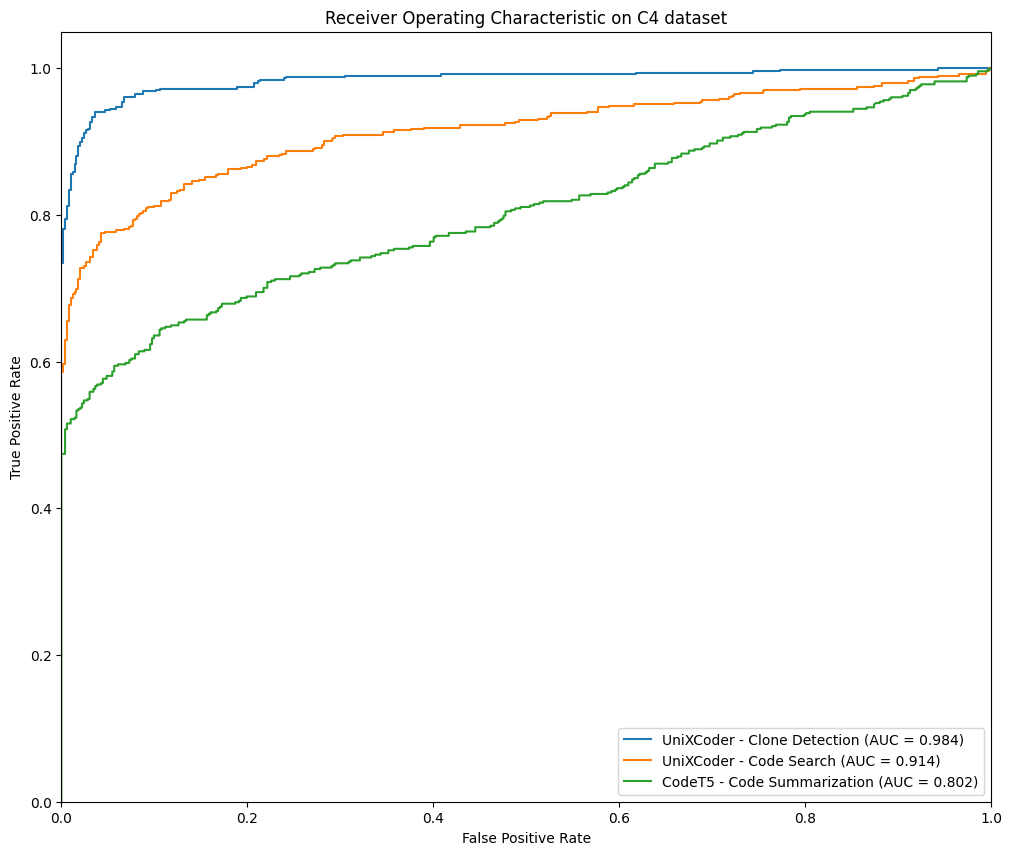

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_auc = {}
fig = plt.figure(figsize=(12, 10))

def roc(y_score, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    model_auc[model_name] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=model_name)

roc(clone_detection_scores, "UniXCoder - Clone Detection")
roc(code_search_scores, "UniXCoder - Code Search")
roc(clone_sum_scores, "CodeT5 - Code Summarization")

# fpr, tpr, thresholds = roc_curve(y_true_orgin, y_pred)
# model_auc["GraphCodeBERT"] = auc(fpr, tpr)
# plt.plot(fpr, tpr, label="GraphCodeBERT")

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

# plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic on C4 dataset')
plt.savefig('roc_c4.png')
plt.show()